# Code to obtain the training set for the RGB/RC classification
* reads in original APOKASC 2 data
* simple cuts in photometry to be able to calculate
* assign 1 to (evstate == 1) or (evstate == 2 and mass > 1.8)
* writes into hdf5 file (working to use hdf5 files from now on)

Code written up by Ioana Ciuca

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
!ls

Classify_RGBs.ipynb  Workflow.txt         data.h5
Data_wrangling.ipynb classify_rgb.py      rgb_rc_training.png


In [3]:
data = Table.read('/Users/ioanaciuca/Desktop/BINGO/BINGO_final/data/AK7dotS35_GDR2pos_APODR14.fits')

(array([1.172e+03, 2.325e+03, 1.017e+03, 4.850e+02, 1.880e+02, 1.050e+02,
        5.400e+01, 2.200e+01, 9.000e+00, 2.000e+00]),
 array([  25.3776 ,  138.70184,  252.02608,  365.3503 ,  478.67456,
         591.9988 ,  705.32306,  818.6473 ,  931.9715 , 1045.2958 ,
        1158.62   ], dtype=float32),
 <a list of 10 Patch objects>)

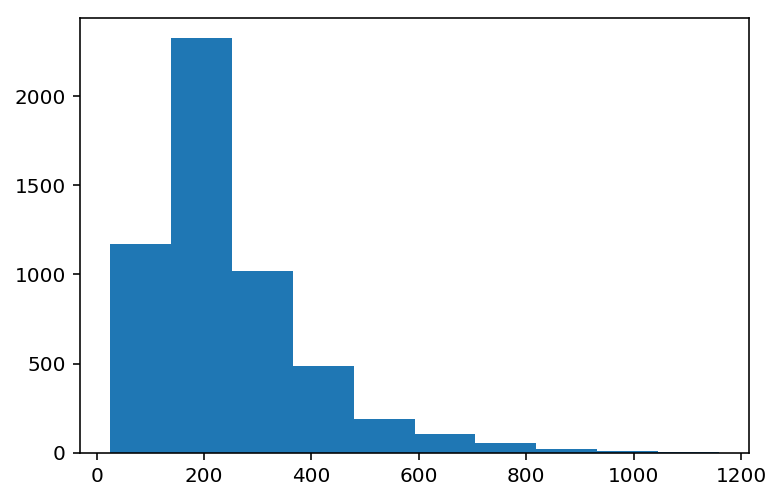

In [4]:
plt.hist(data['SNR'])

It's important to do some quality cuts!

In [5]:
mask = ((data['phot_g_mean_flux'] >= 0) & (data['phot_bp_mean_flux'] > 0) & (data['phot_rp_mean_flux'] > 0) \
& (data['J_ERR'] >=0) & (data['SNR'] >= 100))
data = data[mask]

/Users/ioanaciuca/anaconda3/envs/moreDL/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


(array([2.331e+03, 1.355e+03, 5.940e+02, 3.010e+02, 1.410e+02, 7.800e+01,
        4.300e+01, 1.300e+01, 8.000e+00, 2.000e+00]),
 array([ 100.06   ,  205.916  ,  311.772  ,  417.628  ,  523.484  ,
         629.33997,  735.196  ,  841.052  ,  946.908  , 1052.764  ,
        1158.62   ], dtype=float32),
 <a list of 10 Patch objects>)

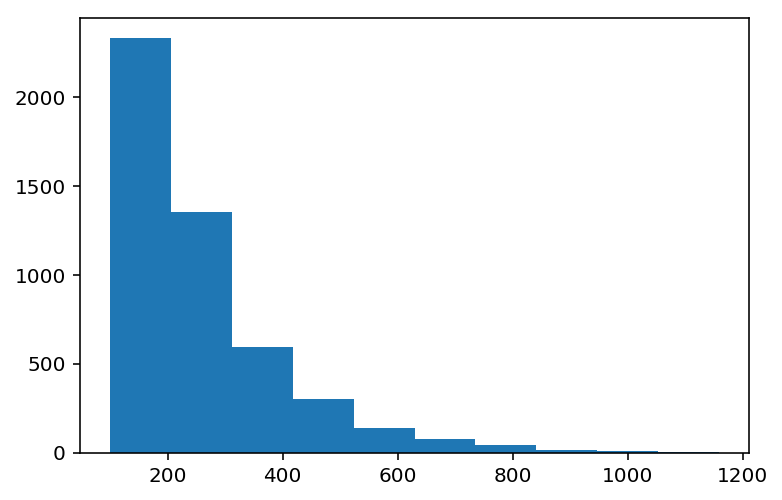

In [6]:
plt.hist(data['SNR'])

In [7]:
print("The length of the data after the quality cuts is", len(data))

The length of the data after the quality cuts is 4866


In [8]:
g_mag = data['phot_g_mean_mag']
g_flux = data['phot_g_mean_flux']
g_flux_error = data['phot_g_mean_flux_error']
gmagErr = 0.5 * 2.5 * (np.log10((g_flux + g_flux_error )/g_flux) - np.log10((g_flux - g_flux_error )/g_flux))

bp_mag = data['phot_bp_mean_mag']
bp_flux = data['phot_bp_mean_flux']
bp_flux_error = data['phot_bp_mean_flux_error']
bpmagErr = 0.5 * 2.5 * (np.log10((bp_flux + bp_flux_error )/bp_flux) - np.log10((bp_flux - bp_flux_error )/bp_flux))

rp_mag = data['phot_rp_mean_mag']
rp_flux = data['phot_rp_mean_flux']
rp_flux_error = data['phot_rp_mean_flux_error']
rpmagErr = 0.5 * 2.5 * (np.log10((rp_flux + rp_flux_error )/rp_flux) - np.log10((rp_flux - rp_flux_error )/rp_flux))

data['G'] = g_mag
data['G_ERR'] = gmagErr

data['BP'] = bp_mag
data['BP_ERR'] = bpmagErr

data['RP'] = rp_mag
data['RP_ERR'] = rpmagErr

In [10]:
N = len(data)

data['class'] = np.zeros(N)

for i in range(N):
    if (data['evstate'][i]==1) or ((data['evstate'][i]==2) and (data['mass'][i]>1.8)):
        data['class'][i]=1
    else:
        data['class'][i]=0

In [11]:
data['class']=[int(x) for x in data['class']]

In [12]:
feats = ['LOGG', 'TEFF', 'ALPHA_M', 'M_H', 'C_FE', 'N_FE', 'O_FE', 'NA_FE',\
           'G', 'BP', 'RP', 'J', 'H', 'K']

featsErr = ['LOGG_ERR', 'TEFF_ERR', 'ALPHA_M_ERR', 'M_H_ERR', 'C_FE_ERR', 'N_FE_ERR', 'O_FE_ERR', 'NA_FE_ERR', \
           'G_ERR', 'BP_ERR', 'RP_ERR', 'J_ERR', 'H_ERR', 'K_ERR']

In [13]:
df = pd.DataFrame()

In [14]:
for feat in feats:
    df[feat]=data[feat]
    
for eFeat in featsErr:
    df[eFeat]=data[eFeat]

In [15]:
df['APOGEE_ID']=data['APOGEE_ID']
df['source_id']=data['source_id']
df['class']=data['class']

In [16]:
df.to_hdf('data.h5', key='df', mode='w', overwrite=True)